# `gridding` - Testing the regular grid maker

This notebook aims at testing the [`gridding`](https://github.com/eurostat/pygridmap/blob/master/pygridmap/gridding.py) module of the [`pygridmap`](https://github.com/eurostat/pygridmap) packages by running basic/simple examples over the `GridMaker` class that is used for creating a regular grid of square unit cells (see [tests](#TestGridMaker)).

## Settings<a id='Settings'></a>

Let's import the necessary packages. First the basic ones:

In [1]:
_THISDIR_ = !pwd 
_THISDIR_ = _THISDIR_[0]

import os, sys
import requests
import warnings
import json
import math, time, timeit
import itertools, functools

then, common (geospatial) data handling libraries:

In [2]:
import numpy as np

try:
     import pandas as pd
except ImportError:
    try:
        !{sys.executable} -m pip install pandas
    except:
        raise IOError("!!! Error importing pandas - this package is required !!!")
    else:
        import pandas as pd
        
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        raise IOError("!!! Error importing geopandas - this package is required !!!")
    else:
        import geopandas as gpd

We also set the CPUs capabilties of this machine:

In [3]:
import multiprocessing as mp

NPROCESSES = NCPUS = mp.cpu_count() 
print("You are running on a machine with \033[1m%s CPUs\033[0m" % NCPUS)

You are running on a machine with 32 CPUs


We import the `matplotlib` plotting package:

In [4]:
import matplotlib.pyplot as mplt
from matplotlib import cm
_FIGSIZE_, _DPI_ = (20,15), 140 
%matplotlib inline

We also import mapping capabilities through the [`folium`](https://python-visualization.github.io/folium/) package for visualisation (you could consider using [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) instead):

In [5]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        pass # print("!!! Error importing folium !!!")
    else:
        import folium

try:
    import branca.colormap as bcm
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        pass # print("!!! Error importing branca !!!")
    else:
        import branca.colormap as bcm

Finally, we import the `pygridmap` package ( _"whatever works"_ ):

In [6]:
try:
    import pygridmap
except ImportError:
    try:
        !{sys.executable} -m pip install git+https://github.com/eurostat/pygridmap.git
        # !{sys.executable} -m pip install pygridmap
    except:
        raise IOError("Sorry, you're doomed: package pygridmap not installed !")
    else:
        print("! Package pygridmap installed on-the-fly !")
finally:        
    from pygridmap.base import FrameProcessor, GridProcessor
    from pygridmap.gridding import DEFPROJ, GridMaker

## Test data<a id='GISCO'></a>

Throughout this notebook, we will set the coverage domain to the internal borders of an arbitrary selected country hence considering the borders as masking geometries for gridding. Using the grid maker, we will build a regular grid over the spatial domain defined by the masking geometries. Note that those geometries are usually multiple, *e.g.* islands are part of the given country. 

Data acquired over Italy (`CTRY_CODE`) are used in this notebook. We will actually retrieve [GISCO](https://ec.europa.eu/eurostat/web/gisco) 2020 reference dataset (`YEAR`) of the country borders at $1m$ resolution (`RESOLUTION`) for the "test data" (`GISCO_BORDER`):

In [7]:
CTRY_CODE = 'IT'
YEAR = 2020
RESOLUTION = '01m' # 1m finest resolution

We set the reference projection (`PROJECTION`) to the Lambert Azimuthal Equal-Area coordinate system ([ETRS89 LAEA](https://spatialreference.org/ref/epsg/etrs89-etrs-laea/), see also [EPSG:23035](https://epsg.io/3035). This system preserves areas. 
Note that this is also consistent with the $1km \times 1km$ [INSPIRE grid](https://inspire.ec.europa.eu/forum/pages/view/4989/european-statistical-1x1km-grid-etrs89-laea).

In [8]:
PROJECTION = "EPSG:3035" # DEFPROJ
PROJ = PROJECTION.split('EPSG:')[1]

Data are fetched from the API. Visit [_GISCO_ API webpage](https://gisco-services.ec.europa.eu/distribution/v2/) for more information:

In [9]:
CTRY = '%s-region-%s-%s-%s' % (CTRY_CODE, RESOLUTION, PROJ, YEAR) # 2020 source
FMT = 'geojson'

try:
    CTRY_NAME = '%s.%s' % (CTRY, FMT)
    assert (os.path.exists(CTRY_NAME) is True)
except:
    CTRY_FILE = ('https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/%s' 
                 % CTRY_NAME)
    try:
        print("Connecting to GISCO webserver")
        resp = requests.get(CTRY_FILE)
        resp.raise_for_status()
    except:
        raise IOError("Error fetching GISCO data: %s" % CTRY_FILE)
    else:
        !wget -O $CTRY_NAME "$CTRY_FILE"
        print('GISCO %s country border data loaded on-disk: \033[1m%s\033[0m' % (CTRY_CODE, CTRY_NAME))
finally:
    GISCO_BORDER = gpd.read_file(CTRY_NAME, driver = FMT)

We report here the min/max coordinates $[x_\min, y_\min, x_\max, y_\max]$ of the spatial domain. This information is used to define the reference bounding box (`GRID_BBOX` and `GRID_FRAME`) of the test dataset:

In [10]:
xmin, ymin, xmax, ymax = GISCO_BORDER.total_bounds

print("Min/max of (x,y) coordinates: \033[1mXmin=%s, Ymin=%s, Xmax=%s, Ymax=%s\033[0m" 
      % (xmin, ymin, xmax, ymax))
print("Extent of the bounding box defined by the (x,y) coordinates: \033[1mX: %sm (%skm) -- Y: %sm (%skm)\033[0m" % 
      (xmax-xmin, round((xmax-xmin)/1000), ymax-ymin, round((ymax-ymin)/1000)))

GRID_BBOX = [xmin, ymin, xmax, ymax] 
# GRID_FRAME = GridProcessor.bbox_to_geoframe(*GRID_BBOX, crs=PROJECTION)
GRID_FRAME = GridProcessor.bbox_to_geoframe(*GRID_BBOX, density=50, crs=PROJECTION)

Min/max of (x,y) coordinates: Xmin=4055215.0, Ymin=1386017.0, Xmax=5049407.0, Ymax=2666694.0
Extent of the bounding box defined by the (x,y) coordinates: X: 994192.0m (994.0km) -- Y: 1280677.0m (1281.0km)


Let's have a quick look at the test data:

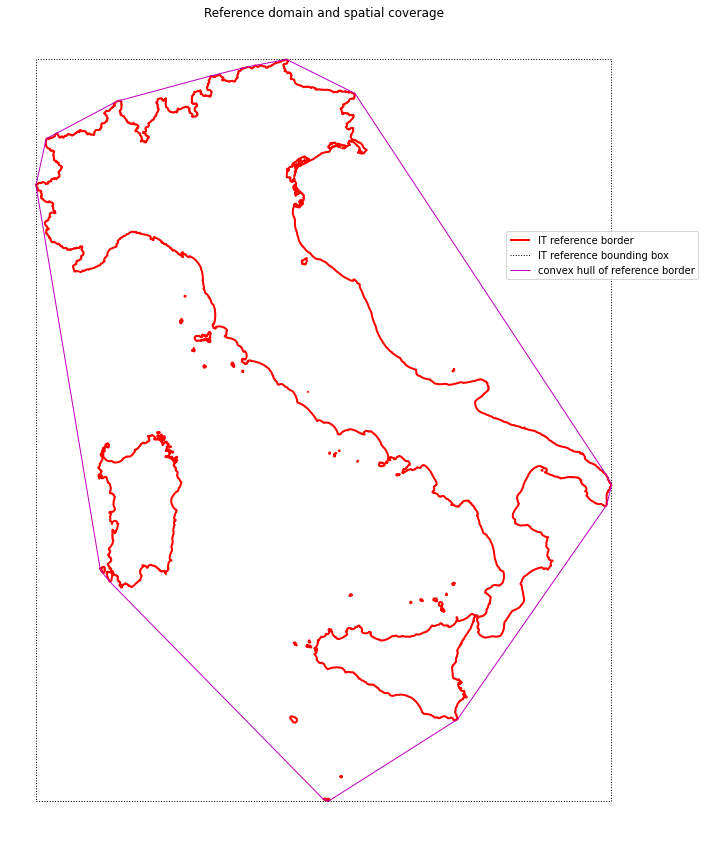

In [11]:
f, ax = mplt.subplots(1,1, figsize=_FIGSIZE_)
GISCO_BORDER.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 2, 
                           label = '%s reference border' % CTRY_CODE) 
GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 1, linestyle = 'dotted', 
                         label = '%s reference bounding box' % CTRY_CODE)
GISCO_BORDER.convex_hull.boundary.plot(ax = ax, edgecolor = 'm', linewidth = 1, 
                                       label = 'convex hull of reference border')
ax.set_title('Reference domain and spatial coverage')
ax.set_axis_off(); ax.legend(bbox_to_anchor=(1.1, .75))
mplt.show()

## Miscellaneous tests<a id='TestGridMaker'></a>

Given the vector polygon layer and its coverage domain above $-$ say $\mathbf{P}$ and $\cal D$ respectively $-$ we aim at building a regular grid $\mathbf{G} \doteq \mathbf{G(\cal s)}$ of "resolution" ${\cal s} = ({\cal w}, {\cal h})$ (in meters):
* with cells $\mathbb{C} \in \mathbf{G}$ that are regular square/rectangle units of dimension ${\cal w} \times {\cal h}$:
$$
\Big\{\begin{array}{l}
{\cal B}(\mathbb{C}) = \mathbb{C} \\
{\cal w}(\mathbb{C}) = {\cal w}, \quad {\cal h}(\mathbb{C}) = {\cal h}
\end{array}
$$
where $\cal B$ designates the bounding box of a geometry while ${\cal w}(\mathbb{C})$ and ${\cal h}(\mathbb{C})$ are the width and size of the cells,
* whose spatial extent, say ${\cal D}_\mathbf{G}$, is also a support for $\cal D$: 
$${\cal D} \subseteq {\cal D}_\mathbf{G} 
\, \Leftrightarrow \,
\forall \, \mathbb{P} \in \mathbf{P}, 
\mathbb{P} \subseteq {\cal U}_\mathbf{G}
$$
where ${\cal U}_\mathbf{G}$ designates the unary union of all geometries (cells) in $\mathbf{G}$.

We will actually compute $\mathbf{G} = \inf_{\mathbf{G(\cal s)} \mid {\cal s}} \big\{ {\cal D} \subseteq {\cal D}_{\mathbf{G(\cal s)}} \big\}$, *i.e.* the grid with the minimal spatial extent is taken over all possible grids of same resolution. 

The most basic operation we want to run is the gridding (unit cells of dimension `CELLSIZE`) of a regular square domain: no "mask" geometry is parsed then. Here, parallel processing (`MODE = 'prll'`) over tiled blocks (`TILESIZE`) is performed: <a id='Test0'></a>

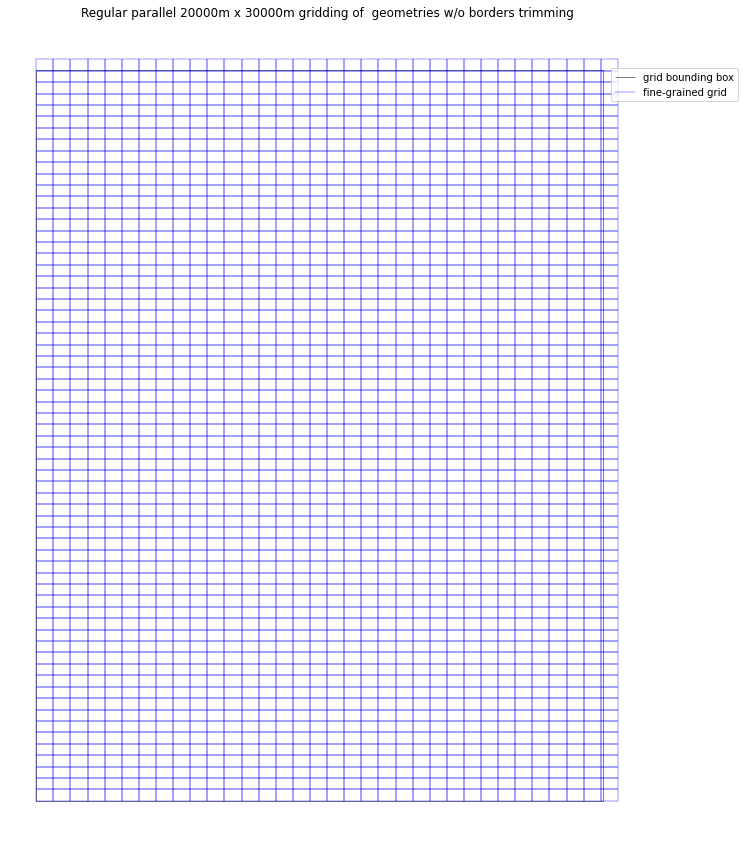

In [12]:
def testGridMaker_0(mode, mask, cellsize, tilesize, interior, trim, crop):
    proc = GridMaker(cores = NPROCESSES, mode = mode, cell = cellsize, tile = tilesize, buffer = False)
    grid = proc(GRID_BBOX, mask = mask, crs = PROJECTION, interior = interior, trim = trim, crop = crop)

    f, ax = mplt.subplots(1, figsize = _FIGSIZE_)
    GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 0.5, label = 'grid bounding box')
    if not (isinstance(mask,bool) or mask is None):
        mask.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 1, label = 'grid cover')
    grid.boundary.plot(ax = ax, edgecolor = 'b', linewidth = 0.4, label = 'fine-grained grid')
    ax.set_title('Regular %s %sm x %sm gridding of %s geometries %s borders trimming' 
                 % ('parallel' if mode=='prll' else 'quadtree', 
                    cellsize[0], cellsize[1], 
                    'interior' if interior is True else '',
                   'w/' if trim is True else 'w/o'))
    ax.set_axis_off(); ax.legend(bbox_to_anchor = (1.15, .95))
    mplt.show()
    
    return grid 

MODE = 'prll' 
CELLSIZE = [20000, 30000] 
TILESIZE = [3, 4]
TRIM = False
_ = testGridMaker_0(MODE, True, CELLSIZE, TILESIZE, False, TRIM, True)

We can actually visualise the geospatial tiling of the spatial domain when using large processing blocks. Note that while the definition of the grid $\mathbf{G} \doteq \mathbf{G}_{\cal s}$ obviously depends on the resolution $\cal s$ of the grid ($\inf$ taken over all $\cal s$ in the definition above), it also depends on the grid offset, *i.e.* the location of the corners of the grid. In the implementation of the `GridOverlay` class,  the bounding box (*e.g.*, `GRID_BBOX`) implicitly provides with this offset, while the mask (*e.g.*, `mask = GISCO_BORDER` in the following) will inform the coverage domain (${\cal D}_\mathbf{G}$):  <a id='Test1'></a>

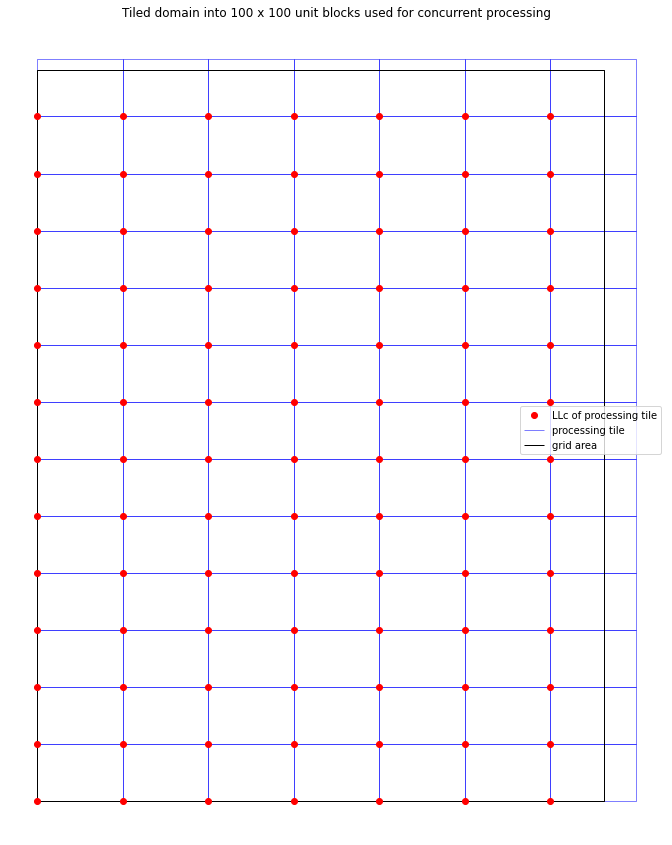

In [13]:
def testGridMaker_1(cellsize, tilesize, trim, crop):
    proc = GridMaker(cores = NPROCESSES, mode = 'prll', cell = cellsize, tile = tilesize)
    tiles = proc(GRID_BBOX, crs = PROJECTION, mask = False, trim = trim, crop = crop)

    nytiles, nxtiles = proc.get_tile_shape(cellsize, tilesize, GRID_BBOX)
    LLc = [proc.get_tile_bbox([iy, ix], cellsize, tilesize, GRID_BBOX, crop = crop)[:2]
           for ix in range(nxtiles) for iy in range(nytiles)]

    f, ax = mplt.subplots(1, figsize = _FIGSIZE_)
    mplt.plot(LLc[0][0], LLc[0][1], 'ro', markersize = 6, label = 'LLc of processing tile')
    [mplt.plot(c[0], c[1], 'ro', markersize = 6) for c in LLc[1:]]
    ax.set_title('Tiled domain into %s x %s unit blocks used for concurrent processing' 
                 % (tilesize[0],tilesize[1]))
    tiles.boundary.plot(ax = ax, edgecolor = 'b', linewidth = 0.5, label = 'processing tile')
    GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 1, label = 'grid area')
    ax.set_axis_off(); ax.legend(loc = 7)
    mplt.show()

    return tiles

CELLSIZE = [1000, 1500] 
TILESIZE = [100, 100] # [350, 250]
TRIM, CROP = False, False
_ = testGridMaker_1(CELLSIZE, TILESIZE, TRIM, CROP)

Following, we perform the gridding of the coverage domain defined by `GISCO_BORDER` (*i.e.*, the spatial domain within the geographical limits defined by the border geometries). Since no trimming (`TRIM = False`) is performed, note the presence of "dumb" unit cells that are not "intersecting" with the coverage domain. Instead, they are present because they belong to processing tile that are actually intersecting with the coverage domain. Instead, those tiles not intersecting are totally ignored: <a id='Test2'></a>

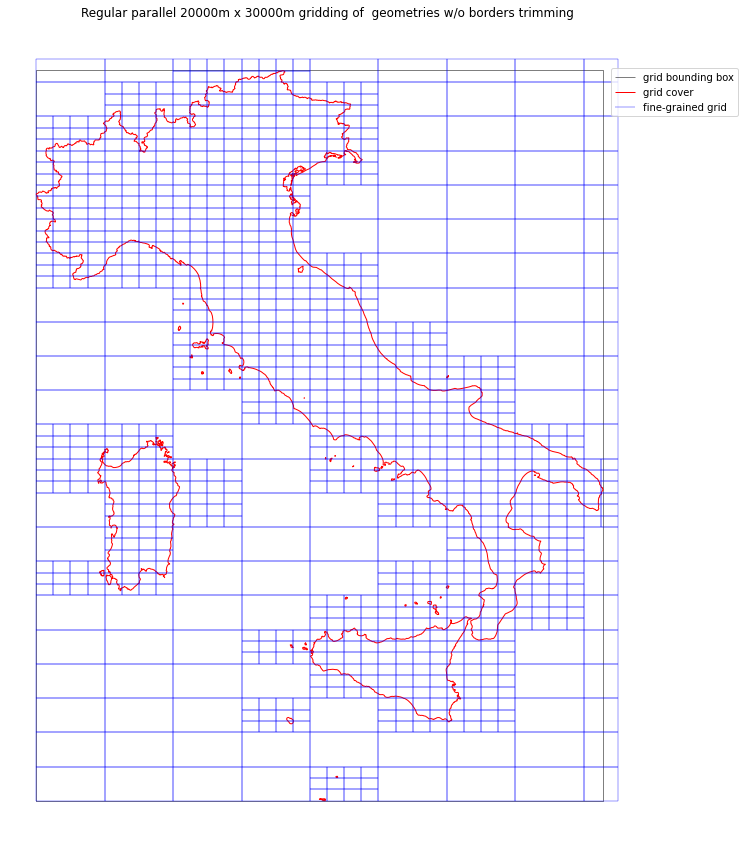

In [14]:
testGridMaker_2 = testGridMaker_0

MODE = 'prll' 
CELLSIZE = [20000, 30000] 
TILESIZE = [3, 4]
TRIM = False
_ = testGridMaker_2(MODE, GISCO_BORDER, CELLSIZE, TILESIZE, False, TRIM, True)

Let's refine the cell dimension (`CELLSIZE`) to run a simple gridding of the mask geometries (`GISCO_BORDER`) without tiling (we force the number of `cores = 1` / `mode = 'seq'`) without trimming of borders (`TRIM = False`): <a id='Test2'></a>

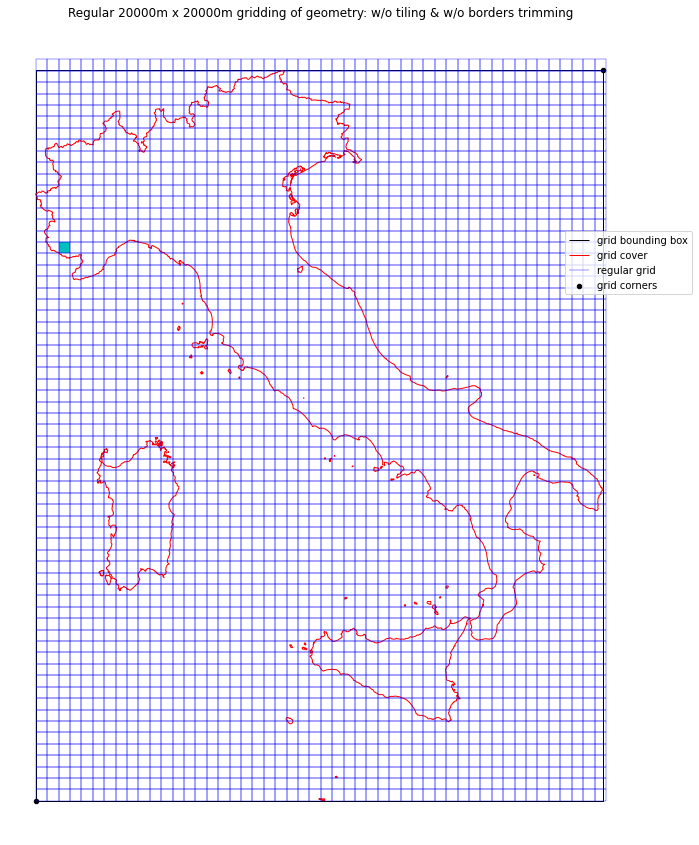

In [15]:
def testGridMaker_2(cellsize, tilesize, trim):
    proc = GridMaker(cores = 1, mode = 'seq', cell = cellsize, tile = tilesize)
    grid = proc(GRID_BBOX, mask = GISCO_BORDER, crs = PROJECTION, trim = trim, crop = False)
    
    rnd_cell = gpd.GeoSeries(grid.iloc[int(np.random.random()*len(grid)),
                                       grid.columns.get_loc('geometry')])

    bound_xy = gpd.GeoDataFrame(geometry = gpd.points_from_xy(GRID_BBOX[0:3:2], GRID_BBOX[1:4:2]), 
                                crs = PROJECTION)

    f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
    GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 1, label = 'grid bounding box')
    GISCO_BORDER.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 1, label = 'grid cover')
    rnd_cell.plot(ax = ax, color = 'c', linewidth = 0.4, label = 'a random unit cell')
    grid.boundary.plot(ax = ax, edgecolor = 'b', linewidth = 0.4, label = 'regular grid')
    bound_xy.plot(ax = ax, color = 'k', markersize = 20, label = 'grid corners')
    ax.set_title('Regular %sm x %sm gridding of geometry: w/o tiling & %s borders trimming' 
                 % (cellsize[0], cellsize[1], 'w/' if trim is True else 'w/o'))
    ax.set_axis_off(); ax.legend(bbox_to_anchor = (1.1, .75))
    mplt.show()

CELLSIZE = [20000, 20000] 
TILESIZE = 1
TRIM = False
testGridMaker_2(CELLSIZE, TILESIZE, TRIM)

Ibid, this time we trim (`TRIM = True`) the unit cells are not intersecting the coverage domain defined by the country borders: <a id='Test3'></a>

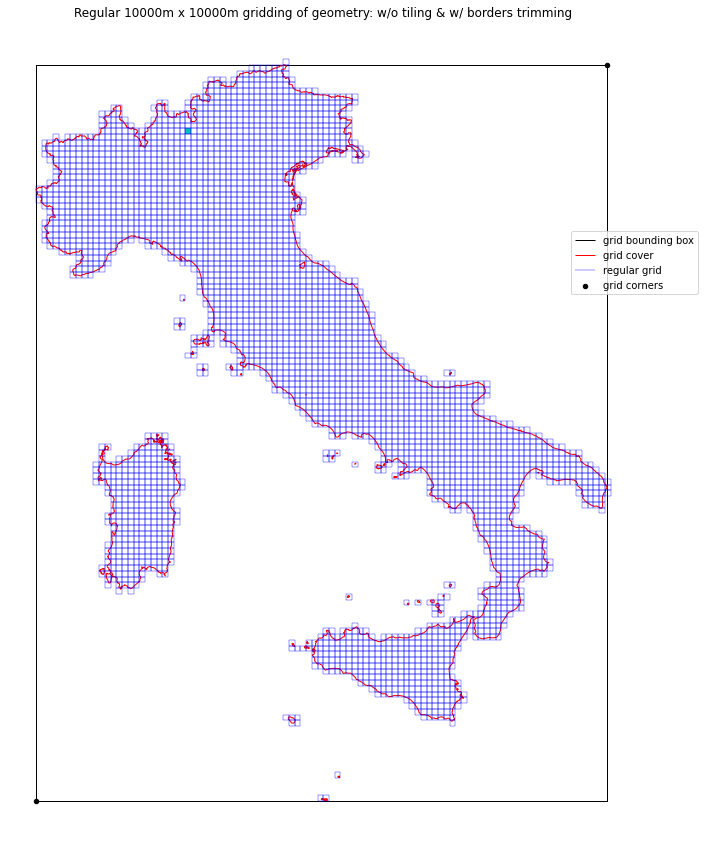

In [16]:
testGridMaker_3 = testGridMaker_2

CELLSIZE = [10000, 10000] 
TILESIZE = [5,5] # 25
TRIM = True
testGridMaker_3(CELLSIZE, TILESIZE, TRIM)

Let's use this time the full machine capabilities (`NPROCESSES`). While still running in parallel (`MODE = 'prll'`), we operate the tiled gridding of the mask geometries. For illustrative purpose we also represent the processing tiles that are either within the borders (*i.e.* completely contained in the coverage domain) or just intersecting with them: <a id='Test4'></a>

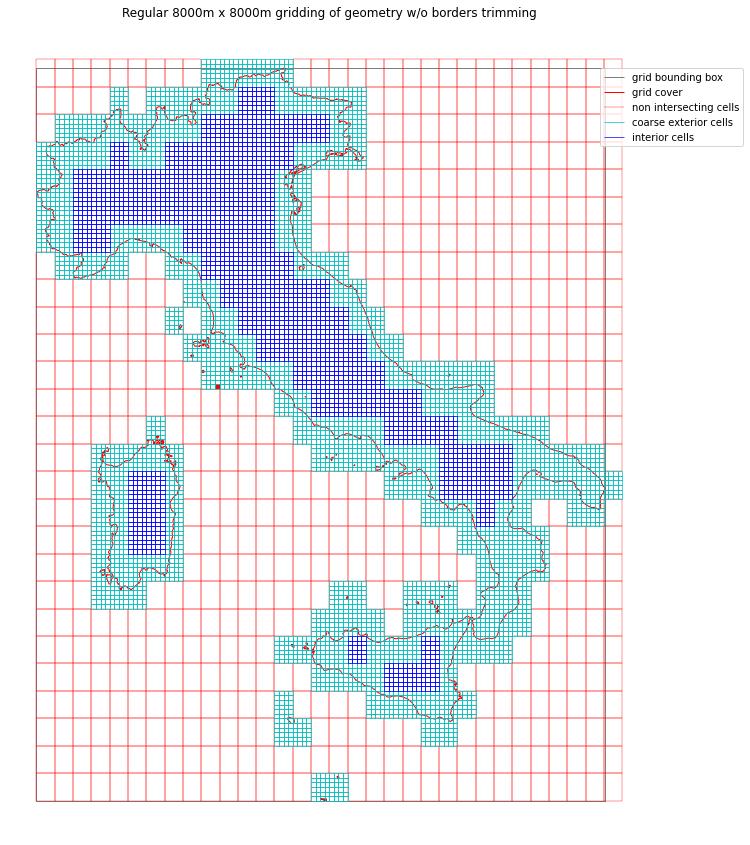

In [17]:
def testGridMaker_4(mode, cellsize, tilesize, trim):
    proc = GridMaker(cores = NPROCESSES, mode = mode, cell = cellsize, tile = tilesize)
    grid = proc(GRID_BBOX, mask = GISCO_BORDER, crs = PROJECTION, trim = trim)
    
    rnd_cell = gpd.GeoSeries(grid.iloc[int(len(grid)/2),grid.columns.get_loc('geometry')])

    f, ax = mplt.subplots(1, figsize = _FIGSIZE_)
    GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 0.5, label = 'grid bounding box')
    GISCO_BORDER.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 1, label = 'grid cover')
    rnd_cell.plot(ax = ax, color = 'r', linewidth = 0.4, label = 'a random unit cell')
    (grid[grid[GridMaker.COL_INTERSECTS] == 0].boundary
     .plot(ax = ax, edgecolor = 'r', linewidth = 0.4, label = 'non intersecting cells')
    )
    (grid[(grid[GridMaker.COL_INTERSECTS] == 1) & (grid[GridMaker.COL_WITHIN]!=1)].boundary
     .plot(ax = ax, edgecolor = 'c', linewidth = 0.7, label = 'coarse exterior cells')
    )
    (grid[(grid[GridMaker.COL_INTERSECTS] == 1) & (grid[GridMaker.COL_WITHIN]==1)].boundary
     .plot(ax = ax, edgecolor = 'b', linewidth = 0.7, label = 'interior cells')
    )
    ax.set_title('Regular %sm x %sm gridding of geometry %s borders trimming' 
                 % (cellsize[0], cellsize[1], 'w/' if trim is True else 'w/o'))
    ax.set_axis_off(); ax.legend(bbox_to_anchor = (1.15, .95))
    mplt.show()

MODE = 'prll'
CELLSIZE = [8000, 8000] 
TILESIZE = [6, 4] # each tile contains 6 x 4 unit cells
TRIM = False
testGridMaker_4(MODE, CELLSIZE, TILESIZE, TRIM)

Ibid while increasing the resolution (although we reuse the `testGridMaker_0` function), but this time we trim the unit cells which are not intersecting with the coverage domain: <a id='Test5'></a>

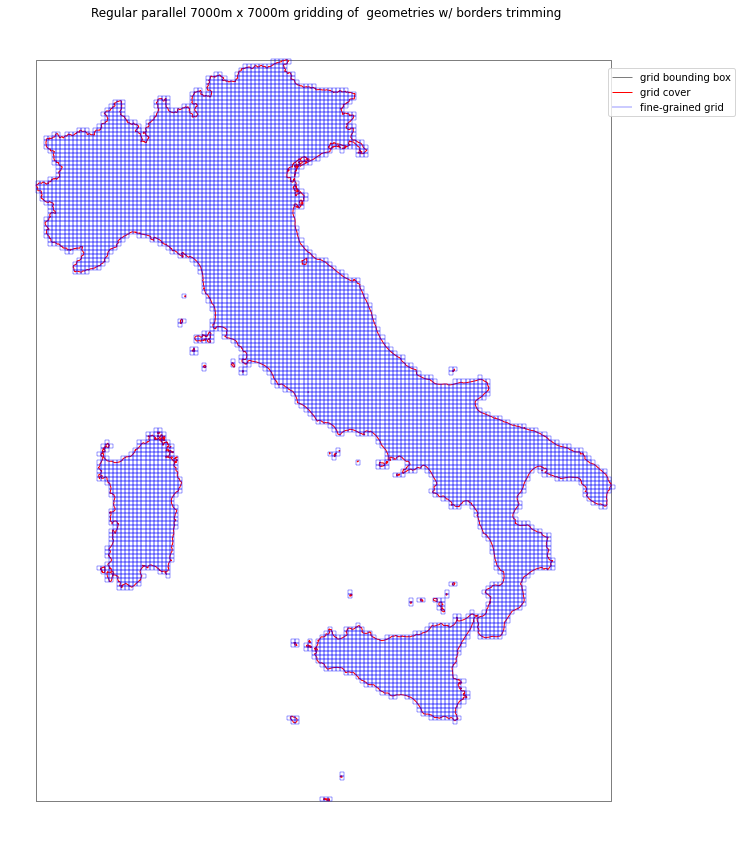

In [18]:
testGridMaker_5 = testGridMaker_0

MODE = 'prll'
CELLSIZE = [7000, 7000] 
TILESIZE = [7, 7] # each tile contains 7 x 7 unit cells, see tiles below
TRIM = True
grid = testGridMaker_5(MODE, GISCO_BORDER, CELLSIZE, TILESIZE, False, TRIM, False)

We can visualise the various processing tiles used for parallel gridding, and check that they are indeed composed of 7$\times$7 unit cells (`TILESIZE = [7, 7]` [above](#Test5)): <a id='Test6'></a>

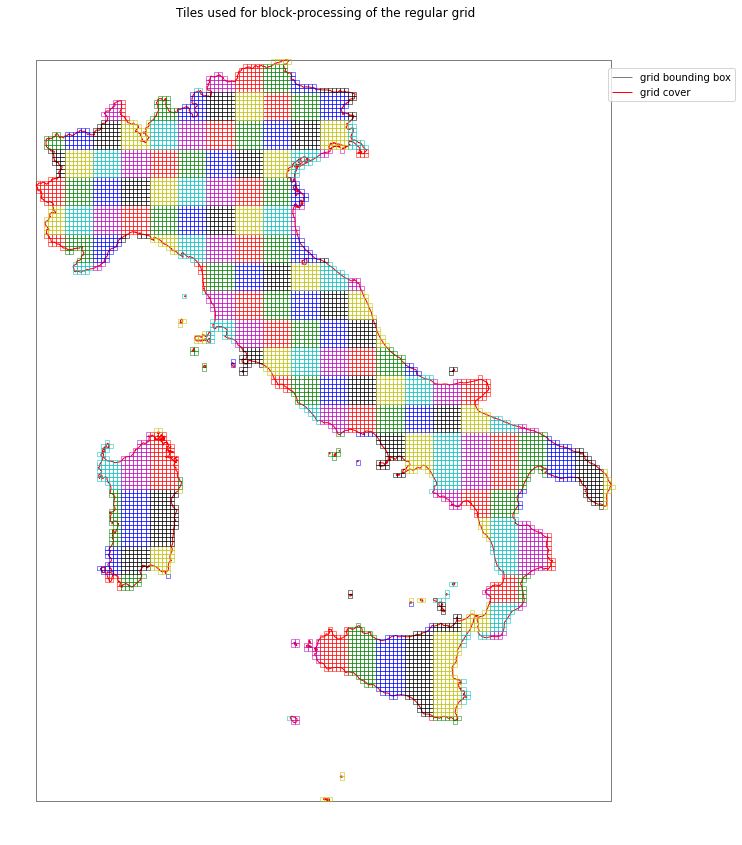

In [19]:
def testGridMaker_6(grid):
    itiles = list(set(grid[GridMaker.COL_TILE].values))

    f, ax = mplt.subplots(1, figsize = _FIGSIZE_)
    GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 0.5, label = 'grid bounding box')
    GISCO_BORDER.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 1, label = 'grid cover')
    [grid[grid[GridMaker.COL_TILE] == it].boundary.plot(ax = ax, edgecolor = x, linewidth = 0.5)
     for x,it in zip(itertools.cycle(['r','g','b','k','y','c','m']),itiles)]
    ax.set_title('Tiles used for block-processing of the regular grid')
    ax.set_axis_off(); ax.legend(bbox_to_anchor = (1.15, .95))
    mplt.show()
    
testGridMaker_6(grid)

One more example, running parallel processing with fine trimming (`TRIM = True`): <a id='Test7'></a>

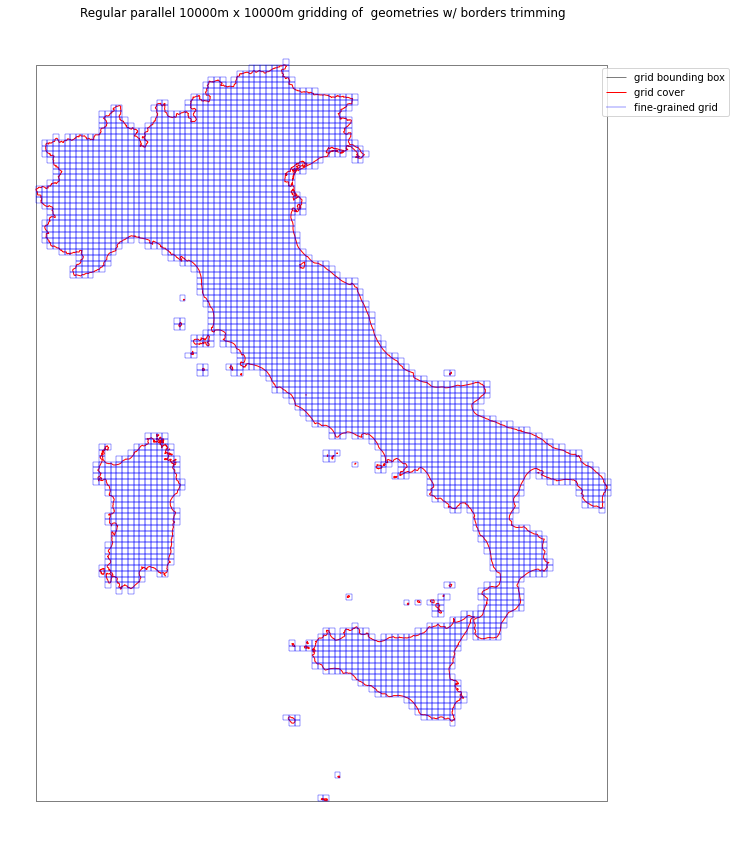

In [20]:
testGridMaker_7 = testGridMaker_0

MODE = 'prll'
CELLSIZE = [10000, 10000] 
TILESIZE = [16, 16]
TRIM, INTERIOR = True, False
grid = testGridMaker_7(MODE, GISCO_BORDER, CELLSIZE, TILESIZE, INTERIOR, TRIM, True)

You can explore the resulting grid (zoom in):

In [21]:
m = folium.Map()

PROJMAP = "EPSG:4326" 
w, s, e, n = GRID_FRAME.to_crs(PROJMAP).total_bounds.tolist()
m.fit_bounds([[s, w], [n, e]])

def mapstyle_function(color, opacity, weight, dotted, x):
    style = {'color':'%s' % color, 
            'fillColor': '#%s' % color,
            'fillOpacity': opacity, 
            'weight': weight}
    if not dotted in (None,False):
        style.update({'dashArray': '10' if dotted is True else dotted})
    return style

folium.GeoJson(
    data = json.loads(GRID_FRAME.to_crs(PROJMAP).to_json()),
    name = 'Grid bounding box (--k)',
    style_function = functools.partial(mapstyle_function, 'black', 0.1, 3, True),
).add_to(m)

folium.GeoJson(
    data = json.loads(grid
                      .boundary
                      .to_crs(PROJMAP)
                      .to_json()),
    name = 'Regular grid (-b)',
    style_function = functools.partial(mapstyle_function, 'blue', 0.001, 5, False),
).add_to(m)

folium.GeoJson(
    data = json.loads(GISCO_BORDER.to_crs(PROJMAP).to_json()),
    name = 'Grid cover (-r)',
    style_function = functools.partial(mapstyle_function, 'red', 0.1, 3, False),
).add_to(m)

folium.LayerControl('topleft', collapsed=False).add_to(m)

m

Last, keeping the same resolution (`CELLSIZE`) while running parallel quadtree (`MODE = 'qtree'`), we output the interior cells only (`INTERIOR = True`), *i.e.* those units cells that are contained in the coverage domain / within the geographical borders (note that some small areas are not covered anymore): <a id='Test8'></a>

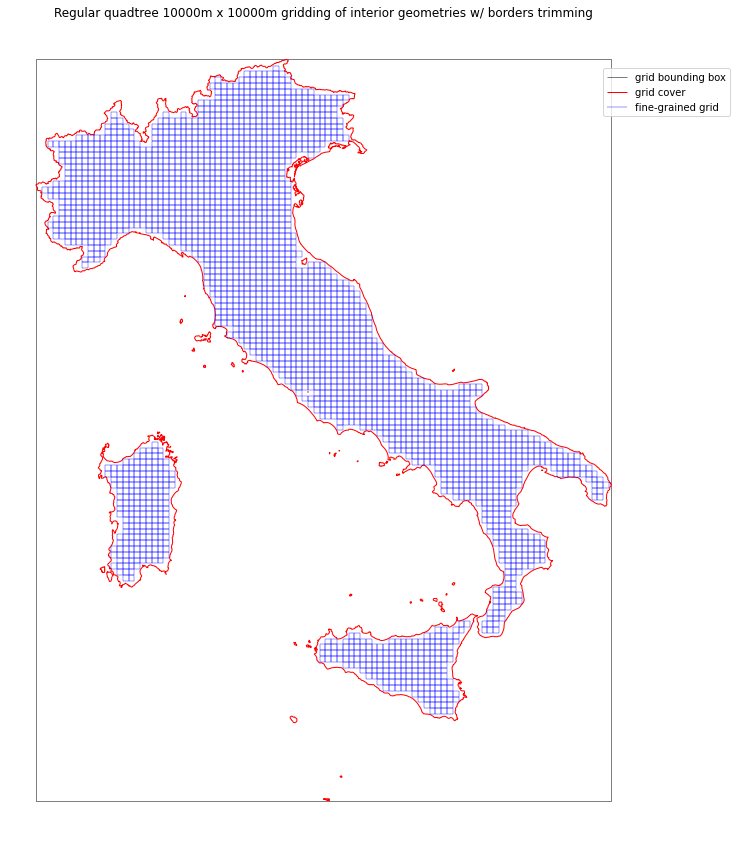

In [22]:
testGridMaker_8 = testGridMaker_0

MODE = 'qtree'
CELLSIZE = [10000, 10000] 
TILESIZE = [16, 16]
TRIM, INTERIOR = True, True
_ = testGridMaker_8(MODE, GISCO_BORDER, CELLSIZE, TILESIZE, INTERIOR, TRIM, False)